The notebook instantiates the initial 16 items that will represent Cherokee Nation Tribal Council districts (15 on the reservation plus the at-large district) in Wikidata. These came up as a need in documenting Cherokee Nation elected officials, but having them as identities will help in other linked data work.

The concept of [electoral district](https://www.wikidata.org/wiki/Q192611) already exists in Wikidata. I added a specific subclass, [electoral district of the Cherokee Nation](https://www.wikidata.org/wiki/Q122976289) following the pattern of other subclasses in other governments.

CN Districts were most recently established under the Cherokee Nation Constitition of 1999 to include 15 on-reservation districts and the at-large district. I have not yet tracked down when and how any geographic boundary changes have occurred since that time, but I have found online data defining the current boundaries via the advertised [CN maps](https://www.cherokee.org/About-The-Nation/Maps).

An item I created, [Constitution of the Cherokee Nation](https://www.wikidata.org/wiki/Q122945957), serves as part of the reference for the district items. I still need to work out how to represent the data source (GIS data service in the CN ArcGIS Enterprise instance) along with the code that does the work.

One thing I am exploring here is how best to represent the cultural dynamics of the Cherokee Nation Tribal Council, whose current members evidence a great deal of connectedness to the communities in their districts and a remarkable level of openness. Cherokee values are evident in the proceedings of the Council online through the Cherokee Nation YouTube channel and the Council's playlists (full council meetings and committees) and in [online documentation](https://cherokee.legistar.com/Legislation.aspx) going clear back to 1976. I want to reflect this through the organization of structured data, particularly in the connection to communities within the Districts and their constituents, which extend well beyond CN citizens in terms of the benefits from CN governance.

In [1]:
import geopandas as gpd
import pandas as pd
import requests
from shapely.geometry import Point
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# GIS Data from the Cherokee Nation
Digging behind the scenes on what was driving the couple of advertised maps from the Cherokee Nation web site, I found an ArcGIS Enterprise instance with an available gallery of data and maps. I need to clarify licensing on the data so that I can determine what I can use and any limitations on producing derivatives. The following codeblock pulls the Cherokee Nation reservation boundary and the Tribal Council Districts.

In [2]:
cn_boundary_query = "https://vmgis4.cherokee.org/server/rest/services/Council_Districts_MIL1/MapServer/1/query?where=1%3D1&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=geojson"
cn_boundary = gpd.read_file(cn_boundary_query)

cn_districts_agis_query = "https://vmgis4.cherokee.org/server/rest/services/Council_Districts_MIL1/MapServer/0/query?where=1%3D1&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=geojson"
cn_districts = gpd.read_file(cn_districts_agis_query)

cn_districts['coord_location'] = cn_districts['geometry'].apply(lambda x: x.centroid if x else None)
cn_districts['lat'] = cn_districts['coord_location'].apply(lambda x: x.y if x else None)
cn_districts['lon'] = cn_districts['coord_location'].apply(lambda x: x.x if x else None)

# Significant Place
I would like the items representing CN electoral districts for Tribal Councilors to link the cities/towns that are a part of the district to help in future linking activity for things like community development projects (water infrastructure, etc.). To identify these, I pull a set of "human settlement" items from Wikidata that are a) within OK counties and b) have point coordinates. I set these up as a geodataframe and run a join between the CN district boundaries and the coordinates for the city/town items.

A reasonable property to use for this is the somewhat generic, significant place (P7153) property, that denotes some type of significant place to/for a subject. In this case, this will represent a municipality that is significant as a population center for constituents within a district.

This is in keeping with what I see as a core Cherokee value exhibited by Tribal Council members regularly in their online meetings and written record - focusing on our people and communities with actions to promote health, wellbeing, and prosperity.

In [3]:
# Query for all towns in Oklahoma
query_ok_towns = """
SELECT ?item ?itemLabel ?coord
WHERE {
  ?ok_county wdt:P31 wd:Q13414760 .
  ?human_settlement_classes wdt:P279* wd:Q486972 .
  ?item wdt:P131 ?ok_county ;
        wdt:P31 ?human_settlement_classes ;
        wdt:P625 ?coord .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

r_ok_towns = requests.get(
    'https://query.wikidata.org/sparql',
    params = {'format': 'json', 'query': query_ok_towns}
)

# Set towns up in dataframe and convert to geodataframe
df_ok_towns = pd.json_normalize(r_ok_towns.json()['results']['bindings'])
df_ok_towns.rename(columns = {'item.value': 'item', 'itemLabel.value': 'itemLabel', 'coord.value': 'coord'}, inplace = True)
df_ok_towns['item'] = df_ok_towns['item'].str.replace('http://www.wikidata.org/entity/', '')
df_ok_towns['coord'] = df_ok_towns['coord'].apply(lambda x: x.split('(')[-1]).apply(lambda x: x.split(')')[0])
df_ok_towns.dropna(subset='coord.datatype', inplace=True)
df_ok_towns = df_ok_towns[['item', 'itemLabel', 'coord']]
df_ok_towns['x'] = df_ok_towns['coord'].apply(lambda x: float(x.split(' ')[0]))
df_ok_towns['y'] = df_ok_towns['coord'].apply(lambda x: float(x.split(' ')[1]))
df_ok_towns.drop(columns='coord', inplace=True)

geometry_ok_towns = [Point(xy) for xy in zip(df_ok_towns['x'], df_ok_towns['y'])]
gdf_ok_towns = gpd.GeoDataFrame(df_ok_towns, geometry=geometry_ok_towns, crs='EPSG:4326')

Once we have all towns in Oklahoma (at least those with point coordinates), we can filter to the towns that are within the Cherokee Nation and then spatially join on the Tribal Council District boundaries to get a list of the Wikidata items representing municipalities within each District that can be added as "significant place" claims on those items.

In [4]:
towns_districts = gpd.sjoin(
    gdf_ok_towns, 
    cn_districts[['District','geometry']], 
    predicate='within'
)

towns_in_districts = towns_districts.groupby('District', as_index=False)['item'].agg(list)
towns_in_districts.head()


,District,item
0,D1,"[Q122554734, Q5884893, Q5879375, Q5879375, Q33..."
1,D10,"[Q122557360, Q122597570, Q14708601, Q3310646, ..."
2,D11,"[Q122546608, Q122541477, Q1942878, Q122572995,..."
3,D12,"[Q2549541, Q122546051, Q809450, Q809450, Q2620..."
4,D13,"[Q122573019, Q122573019, Q1865211, Q122573019,..."


# Representative Images
Another interesting thing I want to do once I clear up the issue with licensing on Cherokee Nation data is drop some items in Wikimedia Commons to link to the districts. One thing that would be useful would be to use locator map image (P242) and provide an image of the district within the context of the Cherokee Nation as a whole. I coud also produce a locator image for the Cherokee Nation within the context of the state of Oklahoma. Starting to produce numerous images that start with the overall boundary of the Cherokee Nation as reaffirmed through McGirt would be interesting in itself.

In the following codeblocks, I explore how to produce these images using publicly available data along with the CN reservation boundary and the CN Council District boundaries from the CN's ArcGIS Enterprise server.

## Locator image for the Cherokee Nation
The first codeblock produces a locator image that could be used with the Cherokee Nation item.

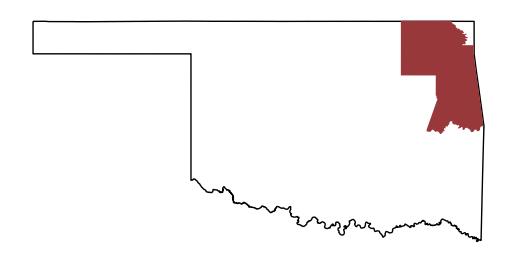

In [5]:
# Access a service to get the OK State boundary as a geodataframe
ok = ox.geocode_to_gdf("Oklahoma, USA")

ax_ok_cn = ok.plot(color='white', edgecolor='black')
cn_boundary.plot(ax=ax_ok_cn, color='#99383B')

ax_ok_cn.set_xticks([])
ax_ok_cn.set_yticks([])
ax_ok_cn.set_xticklabels([])
ax_ok_cn.set_yticklabels([])
ax_ok_cn.set_frame_on(False)

plt.show()

## Locator images for each district
This codeblock produces a locator image for a Tribal Council District within the context of the Cherokee Nation. I fiddled with the idea of highlighting Tahlequah as the Cherokee Nation Capital on these maps and went back and forth with different ways of representing the districts. I think it would be interesting to fiddle with this idea some more and perhaps develop a whole packet of options to use visually in different types of communication, continually reinforcing the image of the Cherokee Nation as a map.

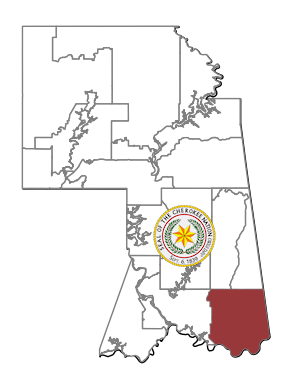

In [11]:
# Get the coordinates for Tahlequah, capital of the Cherokee Nation
cn_capital = towns_districts[towns_districts['itemLabel'] == 'Tahlequah'].iloc[0]
# Get an image of the Cherokee Nation seal to use as the marker for Tahlequah
cn_capital_image = plt.imread('data/cn_seal.png')

# Function to plot the image of the seal at the coordinates of Tahlequah
def plot_image(x, y, image, ax):
    im = OffsetImage(image, zoom=72/ax.figure.dpi)
    im.image.axes = ax
    ab = AnnotationBbox(im, (x,y), frameon=False, pad=0.0)
    ax.add_artist(ab)

# Function to plot the district boundary witin the Cherokee Nation and overlay the capital
def plot_district(district):
    ax_cn = cn_boundary.plot(color='white', edgecolor='black')
    all_districts = cn_districts[cn_districts['District'].notnull()]
    all_districts.plot(ax=ax_cn, color='white', edgecolor='gray')
    d = cn_districts[cn_districts['District'] == district]
    d.plot(ax=ax_cn, color='#99383B')

    ax_cn.set_xticks([])
    ax_cn.set_yticks([])
    ax_cn.set_xticklabels([])
    ax_cn.set_yticklabels([])
    ax_cn.set_frame_on(False)

    plot_image(cn_capital['x'], cn_capital['y'], cn_capital_image, ax_cn)

# Show a particular district
plot_district('D6')
plt.show()

## District Communities
This last idea shows the municipalities/communities plotted within a Tribal Council District, essentially zooming into the District and showing the major population centers. This is another area that would be good to experiment with in different kinds of communication.

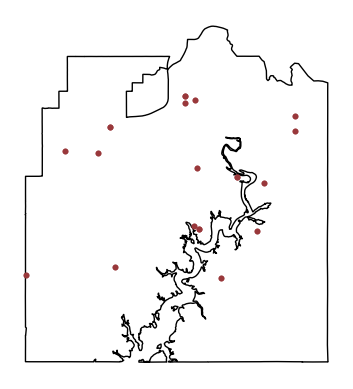

In [14]:
district_num = 'D3'
district = cn_districts[cn_districts['District'] == district_num]
ax_dist = district.plot(color='white', edgecolor='black')
towns_districts[towns_districts['District'] == district_num].plot(ax=ax_dist, color='#99383B', markersize=10)

ax_dist.set_xticks([])
ax_dist.set_yticks([])
ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])
ax_dist.set_frame_on(False)\

plt.show()

# Add Districts to Wikidata
A barebones representation of the 15 on-reservation Tribal Council Districts will do the following:
* set a standardized label and description
* make the item as an instance of an "electoral district of the Cherokee Nation" (Q122976289)
* indicate the country as the USA
* place the District within the territorial entity of the Cherokee Nation
* use the centroid of the District as a point representation
* link municipalities as significant places within the District

I will do other work once the District items are established to finish documenting the current (and some former) Council Members. These will have a reciprocal relationship between the person entity and the district entity. I'll add in the locator images to Wikimedia Commons and link those here once I determine that can be done.

## At-large
The at-large district is a single item that I'll create separately. Here I think it will be interesting to document the [At-large Cherokee Community organizations](https://cherokeesatlarge.org/community-groups/) as distinct Wikidata items. These could be mapped as to their primary gathering locations and used to build a locator image. I'm not sure at this point, though, whether there may be some sensitivities in doing this as I have heard about past tension between on and off reservation dynamics. This would be something to check in with Julia Coates and Johnny Jack Kidwell about.

In [31]:
import os
from wikibaseintegrator import WikibaseIntegrator, wbi_login
from wikibaseintegrator.datatypes import Item, GlobeCoordinate
from wikibaseintegrator.wbi_config import config as wbi_config

wbi_config['USER_AGENT'] = 'Add items representing Cherokee Nation Tribal Council Districts'
login_instance = wbi_login.Login(
    user=os.environ['WD_BOT_USER'],
    password=os.environ['WD_BOT_PASS']
)
wbi = WikibaseIntegrator(login=login_instance)

instance_of_item = 'Q122976289'

In [21]:
cn_districts[cn_districts['District'].str.startswith('D')].head()

,OBJECTID_12,OBJECTID_1,OBJECTID,DIST_ID,DIST_NAME,SHAPE_Leng,District,Count_1,DX_DEV,Count_1_DV,Shape_Le_1,Shape_Length,Shape_Area,geometry,coord_location,lat,lon
2,3,3,32,11,D11,373840.835552,D11,6466,-649,-9.121574,373840.836130,373840.836130,2.948319e+09,"POLYGON ((-95.71087 36.99927, -95.72827 36.999...",POINT (-95.29626 36.75037),36.750366,-95.296260
3,4,4,45,1,D1,369618.418165,D1,6776,-339,-4.764582,369618.417535,369618.417535,7.072252e+08,"MULTIPOLYGON (((-95.09199 36.07559, -95.09315 ...",POINT (-95.17455 35.94851),35.948505,-95.174549
4,5,5,47,3,D3,312903.103410,D3,6553,-562,-7.898805,312903.102910,312903.102910,7.592667e+08,"MULTIPOLYGON (((-94.91401 35.91591, -94.91399 ...",POINT (-94.96339 35.76739),35.767392,-94.963389
5,6,6,50,5,D5,357817.580159,D5,7731,616,8.657765,357817.580680,357817.580680,9.991490e+08,"MULTIPOLYGON (((-95.12727 35.73064, -95.12732 ...",POINT (-95.02385 35.53974),35.539736,-95.023850
6,7,7,51,6,D6,144632.320051,D6,7288,173,2.431483,144632.320916,144632.320916,1.085731e+09,"POLYGON ((-94.67694 35.63827, -94.67976 35.638...",POINT (-94.62803 35.48360),35.483602,-94.628028


In [32]:
# Use the CN Constitution as a reference for instantiation and jurisdiction claims
cn_const_ref = Item(
    prop_nr='P248',
    value='Q122945957'
)

for index, row in cn_districts[cn_districts['District'].str.startswith('D')].iterrows():
    item = wbi.item.new()
    item.labels.set('en', f"Cherokee Nation Tribal Council District {row['DIST_ID']}")
    # Set the basic district identifier as an alias to work within this classification context
    item.aliases.set('en', row['District'])
    item.descriptions.set('en', 'a district of the Cherokee Nation Tribal Council located on the Cherokee Nation Reservation')

    # instance of = Cherokee Nation Tribal Council District
    item.claims.add(
        Item(
            prop_nr='P31',
            value=instance_of_item,
            references=[cn_const_ref]
        )
    )

    # country = USA
    item.claims.add(
        Item(
            prop_nr='P17',
            value='Q30'
        )
    )

    # located in the administrative territorial entity = Cherokee Nation
    item.claims.add(
        Item(
            prop_nr='P131',
            value='Q14708404',
            references=[cn_const_ref]
        )   
    )

    # coordinate location = (lat, lon)
    item.claims.add(
        GlobeCoordinate(
            prop_nr='P625',
            latitude=row['lat'],
            longitude=row['lon']
        )
    )

    # Add links to municipalities in district
    significant_places_claims = []
    for town_id in towns_in_districts[towns_in_districts['District'] == row['District']]['item'].iloc[0]:
        significant_places_claims.append(
            Item(
                prop_nr='P7153',
                value=town_id
            )
        )
    item.claims.add(significant_places_claims)

    # Write the item to Wikidata
    response = item.write(
        summary='Added item representing a Cherokee Nation Tribal Council District'
    )
    print(row['District'], response.id)

D11 Q122984820
D1 Q122984821
D3 Q122984822
D5 Q122984823
D6 Q122984824
D12 Q122984825
D13 Q122984826
D14 Q122984827
D4 Q122984828
D2 Q122984829
D10 Q122984830
D9 Q122984832
D15 Q122984833
D7 Q122984834
D8 Q122984835


### Significant Place Qualifiers
After running through to add the districts, I found that the significant place claim is constrained to require a qualifier indicating the role that the place plays with regard to the subject item. I opted to use the concept of a [population center](https://www.wikidata.org/entity/Q852031) as the object of this qualifier as this seems to make the most sense in this context. It would actualy be interesting to experiment with this over time as we could add more sophistication here in terms of the roles that various townships play in the District.

The following codeblock runs back through the items created starting with a SPARQL query and replaces the significant place claims with properly qualified claims.

In [38]:
# Query for all newly created district items
query_districts = f"""
SELECT ?item
WHERE {{
  ?item wdt:P31 wd:{instance_of_item} .
}}
"""

r_districts = requests.get(
    'https://query.wikidata.org/sparql',
    params = {'format': 'json', 'query': query_districts}
)

district_items = [i['item']['value'].split('/')[-1] for i in r_districts.json()['results']['bindings']]

In [45]:
from wikibaseintegrator.wbi_enums import ActionIfExists

# center of population qualifier
place_qualifier = Item(
    prop_nr='P3831',
    value='Q852031'
)

for district_wd_id in district_items:
    item = wbi.item.get(district_wd_id)
    place_claims = item.claims.get('P7153')

    significant_place_claims = []
    for c in place_claims:
        significant_place_claims.append(
            Item(
                prop_nr='P7153',
                value=c.mainsnak.datavalue['value']['id'],
                qualifiers=[place_qualifier]
            )
        )
    item.claims.add(significant_place_claims, action_if_exists=ActionIfExists.REPLACE_ALL)

    response = item.write(
        summary='Added center of population qualifier to significant places'
    )
    print(response.id)


Q122984820
Q122984821
Q122984822
Q122984823
Q122984824
Q122984825
Q122984826
Q122984827
Q122984828
Q122984829
Q122984830
Q122984832
Q122984833
Q122984834
Q122984835
